In [1]:
import mlrose
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import (cross_val_score, GridSearchCV, 
                                     train_test_split, StratifiedShuffleSplit)
from sklearn.model_selection import learning_curve

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")


/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
def _gridSearchCV(estimator, param_grid, X, y, test_size=0.2):
    grid_search = GridSearchCV(
        estimator=estimator(),
        param_grid=param_grid,
        cv=StratifiedShuffleSplit(n_splits=10, test_size=test_size),
        scoring=metrics.make_scorer(metrics.roc_auc_score),
        n_jobs=-1
    )
    grid_search.fit(X, y)
    return grid_search

def calc_learning_curve(estimator, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    return train_sizes, train_scores, test_scores

def plot_learning_curve(title, train_sizes, train_scores, test_scores, ylim=None):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

#Save the metrics
def getPerfMetrics(gridSearchCVmodel, X, y, model_name, pos_name, neg_name):
    gs = gridSearchCVmodel
    
    gs_res = pd.DataFrame(gs.cv_results_)

    y_pred = gs.predict(X)

    accuracy = metrics.accuracy_score(y, y_pred)
    AUROC = gs.score(X, y)
    confusion_matrix= metrics.confusion_matrix(y, y_pred)
    prfs = metrics.precision_recall_fscore_support(y, y_pred)

    confusion_matrix_frac = confusion_matrix / prfs[3].sum()
    confusion_matrix_frac = pd.DataFrame(confusion_matrix_frac, 
             columns=['pred '+neg_name, 'pred '+pos_name],
            index=['actual '+neg_name, 'actual '+pos_name])

    params = pd.DataFrame(
        gs.best_params_,
        index=[model_name+" best parameters"]
    )
    gen_results = pd.DataFrame(
        {'Accuracy': accuracy,
         'AUROC-score': AUROC
        },
        index=[model_name]
    )
    class_results = pd.DataFrame(
         {'Precision': prfs[0],
         'Recall': prfs[1],
         'F-score': prfs[2],
         'Support': prfs[3]
         },
        index=[pos_name,neg_name]
    )

    return gs.cv_results_, params, gen_results, class_results, confusion_matrix_frac

In [3]:
# Adult dataset

#The adults dataset was downloaded from https://www.kaggle.com/uciml/adult-census-income
#adults = pd.read_csv('adult/adult.csv')

#df = pd.read_csv('datasets/adult/adult.data.txt', header=None)
adults = pd.read_csv('https://raw.githubusercontent.com/sventopia/ML/master/datasets/adult/adult.data.txt', header=None)
adults.columns = ['age','workclass','fnlwgt','education','education-num','marital-status',
                  'occupation','relationship','race','sex','capital-gain','capital-loss',
                  'hours-per-week','native-country','income']
adults.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
adults.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [5]:
adults = adults.drop(['capital-gain','capital-loss'], axis=1)
#split off the response variable
y = adults['income'].to_frame()
X = adults.loc[:, adults.columns != 'income']

#encode the target variable
le = LabelEncoder()
y_enc = le.fit_transform(y.values.ravel())

#encode dummy variables
X_enc = pd.get_dummies(X)

scaler = StandardScaler()
X_std = scaler.fit_transform(X_enc)

In [6]:
param_grid = [{
    'hidden_layer_sizes': [(n,) for n in list(range(1,15,1))],
    'solver': ['lbfgs','sgd','adam'],
    'activation': ['relu','logistic'],
    'learning_rate': ['constant','invscaling']
}]
gs_mlp_a = _gridSearchCV(
    MLPClassifier, 
    param_grid,
    X_std, 
    y_enc)

#Calculate the learning curve
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.1)
estimator = MLPClassifier(**gs_mlp_a.best_params_)
mlp_a_train_sizes, mlp_a_train_scores, mlp_a_test_scores = calc_learning_curve(
    estimator, X_std, y_enc, cv=cv)

In [7]:
#Save the metrics
model_name = 'Neural Network'
pos_class = '> $50k'
neg_class = '<= $50k'
cv_res_mlp_a, params_mlp_a, gen_res_mlp_a, class_res_mlp_a, conf_mat_mlp_a = getPerfMetrics(gs_mlp_a, X_std, y_enc, model_name, pos_class, neg_class)

In [8]:
params_mlp_a

,activation,hidden_layer_sizes,learning_rate,solver
Neural Network best parameters,logistic,2,constant,sgd


In [9]:
gen_res_mlp_a

,Accuracy,AUROC-score
Neural Network,0.835232,0.763344


In [10]:
class_res_mlp_a

,Precision,Recall,F-score,Support
> $50k,0.883404,0.902023,0.892616,24720
<= $50k,0.669126,0.624665,0.646132,7841


In [11]:
conf_mat_mlp_a

,pred <= $50k,pred > $50k
actual <= $50k,0.684807,0.074383
actual > $50k,0.090384,0.150425


<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

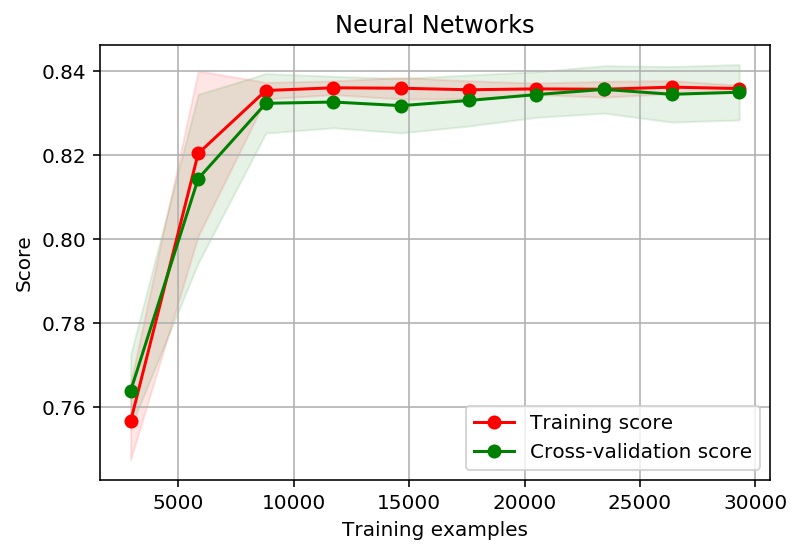

In [12]:
#Print the learning curve
title = "Neural Networks"
plot_learning_curve(title, mlp_a_train_sizes, mlp_a_train_scores, mlp_a_test_scores)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y_enc, test_size = 0.2, 
                                                    random_state = 3)

In [28]:
# Initialize neural network object and fit object - attempt 1
nn_model1 = mlrose.NeuralNetwork(hidden_nodes = [2], activation ='relu', 
                                 algorithm ='random_hill_climb', 
                                 max_iters = 1000, bias = True, is_classifier = True, 
                                 learning_rate = 0.0001, early_stopping = True, 
                                 clip_max = 5, max_attempts = 100, random_state = 3)


In [29]:
nn_model1.fit(X_train, y_train)

NeuralNetwork(bias=True, clip_max=5, early_stopping=True, hidden_nodes=[2],
              is_classifier=True, learning_rate=0.0001, max_iters=1000,
              mutation_prob=0.1, pop_size=200, restarts=0,
              schedule=<mlrose.decay.GeomDecay object at 0x7fadd9756890>)

In [23]:
y_train_pred = nn_model1.predict(X_train)

y_train_accuracy = accuracy_score(y_train, y_train_pred)

print(y_train_accuracy)

0.7597128378378378


In [24]:
# Predict labels for test set and assess accuracy
y_test_pred = nn_model1.predict(X_test)

y_test_accuracy = accuracy_score(y_test, y_test_pred)

print(y_test_accuracy)

0.7571011822508829


In [35]:
import mlrose_hiive
param_grid = [{
    'hidden_nodes' : [2], 
    'activation' : ['relu'], 
    'algorithm' : ['random_hill_climb'], 
    'max_iters' : [1000], 
    'bias' : [True], 
    'is_classifier' : [True],                     
    'learning_rate' : [0.0001], 
    'early_stopping' : [True],               
    'clip_max' : [5], 
    'max_attempts' : [100], 
    'random_state' : [3]
}]
gs_mlp_a = _gridSearchCV(
    mlrose_hiive.NeuralNetwork, 
    param_grid,
    X_std, 
    y_enc)

#Calculate the learning curve
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.1)
estimator = mlrose_hiive.NeuralNetwork(**gs_mlp_a.best_params_)
mlp_a_train_sizes, mlp_a_train_scores, mlp_a_test_scores = calc_learning_curve(
    estimator, X_std, y_enc, cv=cv)

TypeError: 'int' object is not iterable

In [36]:
state = np.array([1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0])

In [37]:
fitness = mlrose.FourPeaks(t_pct=0.15)

In [38]:
problem = mlrose.DiscreteOpt(length = len(state), fitness_fn = fitness, maximize = True, max_val = 1)

In [43]:
best_state, best_fitness_, fitness_curve = mlrose_hiive.random_hill_climb(problem, max_attempts=10, max_iters=np.inf, restarts=0, init_state=None, curve=True, random_state=None)

ValueError: low >= high